In [1]:
import arepo_run as arun
import matplotlib.pylab as plt
import numpy as np
import gadget
import h5py
# import yt
# import cmasher

#Some constants
gamma    = 5./3
unit_m   = 1.989e43
unit_v   = 1.e5
unit_l   = 3.09567758e21
unit_t   = unit_l/unit_v
unit_rho = unit_m/unit_l**3




In [15]:
#Snapshot
num  = 0
#Read
o  = arun.Run(snappath='/cosma8/data/dp317/dc-naza3/gasCloudNfw/output', snapbase="snap_")
s  = o.loadSnap(snapnum=num)

In [16]:
s.data.keys()

dict_keys(['flga', 'wind', 'pos', 'rho', 'grar', 'u', 'mass', 'id', 'pres', 'vel', 'vol', 'vort', 'type'])

In [2]:
from radial_plots import *

In [29]:
def rvsval(value='rho', snappath='', num=0, nbins=100, shock = True):
    
    #Read
    o  = arun.Run(snappath=snappath, snapbase="snap_")
    s  = o.loadSnap(snapnum=num)

    gamma = 5./3
    unit_v = 1e5

    # ---- derived quantities ----
    if value == 'temp':
        kB = 1.381e-16
        mP = 1.66e-24
        xH = 0.76
        meanMolecularWeight = 0.6*mP #4*mP / (1 + 3*xH + 4*xH * s.data['ne'])
        s.data['temp'] = (gamma - 1) * meanMolecularWeight / kB * s.data['u'] * unit_v**2

    if value == 'speed':
        s.data['speed'] = np.linalg.norm(s.data['vel'], axis=1)

    if value == 'vortmag':
        s.data['vortmag'] = np.linalg.norm(s.data['vortmag'], axis=1)

    if value == 'grar_rho':
        s.data['grar_rho'] = np.linalg.norm(s.data['grar'], axis=1) / s.data['rho']
    
    if value == 'energdens':
        s.data['energdens'] = s.data['u']*s.data['rho']

    filepath = f'/cosma8/data/dp317/dc-naza3/gasCloudNfw/shocks_pp/shocks_{num:03d}.hdf5'

    if shock:
        with h5py.File(filepath, "r") as shocks_file:
            s.data['shocks_coords']     = shocks_file["Coordinates"][:]
            s.data['temperature']       = shocks_file["Temperature"][:]
            s.data['preshock_temp']     = shocks_file["PreShockTemperature"][:]
            s.data['mach']              = shocks_file["Machnumber"][:]
            s.data['shock_direction']   = shocks_file["ShockDirection"][:]
            s.data['preshock_rho']      = shocks_file["PreShockDensity"][:] * unit_rho
            s.data['postshock_rho']     = shocks_file["PostShockDensity"][:] * unit_rho
            s.data['preshock_p']        = shocks_file["PreShockPressure"][:]
            s.data['postshock_p']       = shocks_file["PostShockPressure"][:]
            s.data['preshock_v']        = shocks_file["PreShockVelocity"][:]
            s.data['postshock_v']       = shocks_file["PostShockVelocity"][:]
            s.data['surf']              = shocks_file["Surface"][:]    
            s.data['uflux']         = shocks_file["GeneratedInternalEnergyFlux"][:]
            s.data['edis']          = s.data['uflux']*s.data['surf'] 
        
        # Find the mapping from shocks_coords to pos
        from scipy.spatial import cKDTree

        # Build a KDTree for fast nearest neighbor lookup
        tree = cKDTree(s.data['shocks_coords'])
        _, indices = tree.query(s.data['pos'])

        # Reorder all shock parameters to match pos ordering
        shock_params = ['temperature', 'preshock_temp', 'mach', 'shock_direction', 
                        'preshock_rho', 'postshock_rho', 'preshock_p', 'postshock_p',
                        'preshock_v', 'postshock_v', 'surf', 'uflux', 'edis']

        for param in shock_params:
            if param in s.data:
                s.data[param] = s.data[param][indices]

        # Now shocks_coords should match pos
        s.data['shocks_coords'] = s.data['shocks_coords'][indices]

    #Centre of Box
    xc = 500.
    yc = 500.
    zc = 500.

    xx    = s.data['pos'][:,0] - xc
    yy    = s.data['pos'][:,1] - yc
    zz    = s.data['pos'][:,2] - zc
    rr = np.sqrt(xx*xx + yy*yy + zz*zz)

    # Create radial bins and compute average value in each bin
    r_bins = np.logspace(np.log10(rr.min()), np.log10(rr.max()), nbins)
    r_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
    
    # Bin the data and compute mean
    bin_indices = np.digitize(rr, r_bins)
    val_binned = np.array([s.data[value][bin_indices == i].mean() 
                           for i in range(1, len(r_bins))])
    
    return r_centers, val_binned




In [16]:
val = 'mach'

r_shockll =[]
r_shockhl =[]
# Plot lines for all snapshots  
for i in range(13):
    radial_range = (3.16, 100)
    snappath = '/cosma8/data/dp317/dc-naza3/gasCloudNfw/output/'
    shock_path = snappath + f'shocks_{i:03d}.hdf5'
    o  = arun.Run(snappath=snappath, snapbase="snap_")
    s  = o.loadSnap(snapnum=i)
    r_plotll, val_plotll = radial_profile(s=s, value=val, radial_range=radial_range, nbins=1000, post_shock=True, shock_path=shock_path)

    snappath = '/cosma8/data/dp317/dc-naza3/gasCloudNfw/output2/'
    o  = arun.Run(snappath=snappath, snapbase="snap_")
    s  = o.loadSnap(snapnum=i)
    r_plothl, val_plothl = radial_profile(s=s, value=val, radial_range=radial_range, nbins=1000, post_shock=False)

    r_shockll.append(r_plotll[np.nanargmax(val_plotll)])
    r_shockhl.append(r_plothl[np.nanargmax(val_plothl)])

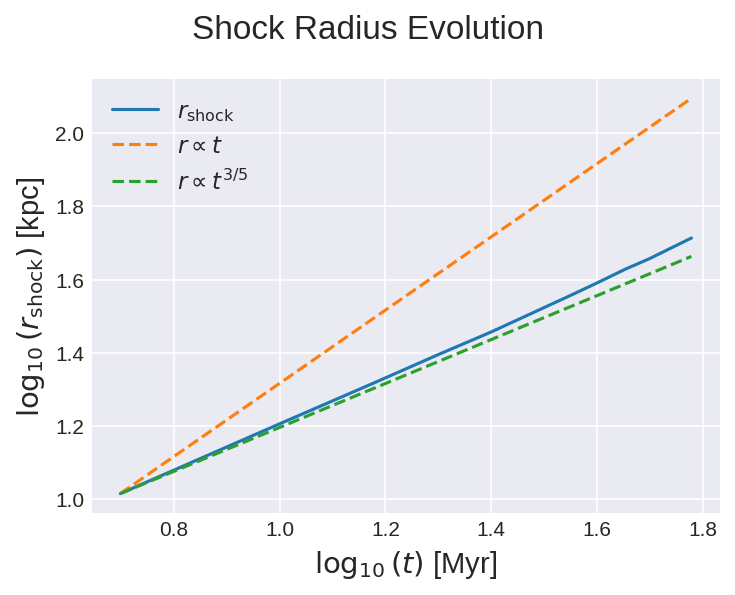

In [18]:
r_shockll = np.array(r_shockhl)
# Fit a straight line in log-log space to find the exponent
# Calculate time array in Myr
snapshot_interval_myr = 5  # Myr
snapshots = np.arange(len(r_shockll))
time_myr = snapshots * snapshot_interval_myr

plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(5, 4), dpi=150)

# Plot r_shock
ax.plot(np.log10(time_myr[time_myr > 0]), np.log10(r_shockll[time_myr > 0]), '-', label=r'$r_{\rm shock}$', color='tab:blue')

# Reference lines: r ∝ t and r ∝ t^{3/5}
t_ref = np.linspace(time_myr[1], time_myr[-1], 100)
# Normalize so all curves start at the same initial r
r0 = r_shockll[1] if r_shockll[1] > 0 else 1.0

# Fix reference lines to avoid log(0)
t_ref_nonzero = t_ref[t_ref > 0]
r_t1_fixed = r0 * (t_ref_nonzero / t_ref_nonzero[0])
r_t35_fixed = r0 * (t_ref_nonzero / t_ref_nonzero[0])**(3/5)
# r_t7_fixed = r0 * (t_ref_nonzero / t_ref_nonzero[0])**(0.7)
ax.set_xlabel(r'$\log_{10}(t)$ [Myr]', fontsize=14)
ax.set_ylabel(r'$\log_{10}(r_{\rm shock})$ [kpc]', fontsize=14)
fig.suptitle('Shock Radius Evolution', fontsize=16)

ax.plot(np.log10(t_ref_nonzero), np.log10(r_t1_fixed), '--', color='tab:orange', label=r'$r \propto t$')
ax.plot(np.log10(t_ref_nonzero), np.log10(r_t35_fixed), '--', color='tab:green', label=r'$r \propto t^{3/5}$')
# ax.plot(np.log10(t_ref_nonzero), np.log10(r_t7_fixed), '--', color='tab:red', label=r'$r \propto t^{0.7}$')
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

In [ ]:
# We fit log(r_shock) vs log(time_myr) to get r_shock ∝ t^alpha
mask_fit = time_myr > 0  # Only use non-zero times
coeffs = np.polyfit(np.log10(time_myr[mask_fit]), np.log10(r_shock[mask_fit]), 1)
alpha = coeffs[0]  # The slope is the exponent
intercept = coeffs[1]

print(f"Best fit: r_shock ∝ t^{alpha:.3f}")

# Create fitted line for plotting
r_fit = 10**intercept * time_myr[mask_fit]**alpha

Best fit: r_shock ∝ t^0.717


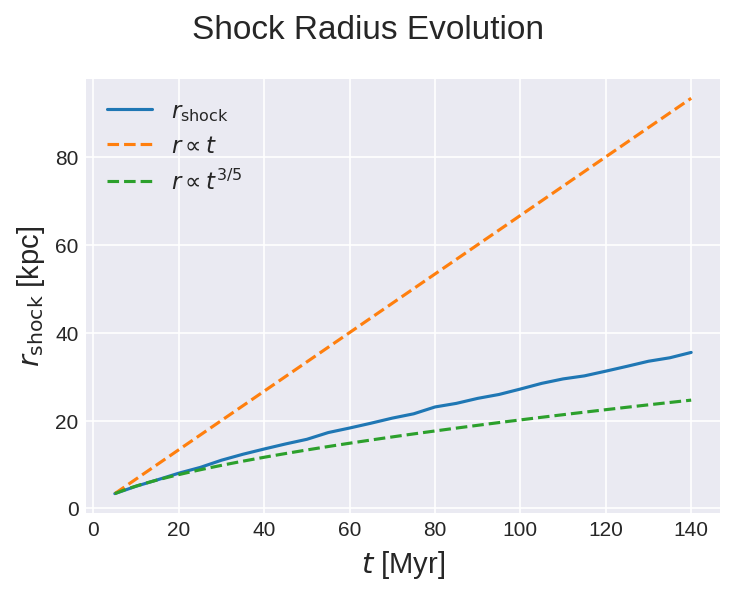

In [ ]:
r_shock = np.array(r_shock)

# Fit a straight line in log-log space to find the exponent
# Calculate time array in Myr
snapshot_interval_myr = 5  # Myr
snapshots = np.arange(len(r_shock))
time_myr = snapshots * snapshot_interval_myr

plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(5, 4), dpi=150)

# Plot r_shock
ax.plot(time_myr[time_myr > 0], r_shock[time_myr > 0], '-', label=r'$r_{\rm shock}$', color='tab:blue')

# Reference lines: r ∝ t and r ∝ t^{3/5}
t_ref = np.linspace(time_myr[1], time_myr[-1], 100)
# Normalize so all curves start at the same initial r
r0 = r_shock[1] if r_shock[1] > 0 else 1.0

# Fix reference lines to avoid log(0)
t_ref_nonzero = t_ref[t_ref > 0]
r_t1_fixed = r0 * (t_ref_nonzero / t_ref_nonzero[0])
r_t35_fixed = r0 * (t_ref_nonzero / t_ref_nonzero[0])**(3/5)
# r_t7_fixed = r0 * (t_ref_nonzero / t_ref_nonzero[0])**(0.7)
ax.set_xlabel(r'$t$ [Myr]', fontsize=14)
ax.set_ylabel(r'$r_{\rm shock}$ [kpc]', fontsize=14)
fig.suptitle('Shock Radius Evolution', fontsize=16)

ax.plot(t_ref_nonzero, r_t1_fixed, '--', color='tab:orange', label=r'$r \propto t$')
ax.plot(t_ref_nonzero, r_t35_fixed, '--', color='tab:green', label=r'$r \propto t^{3/5}$')
# ax.plot(t_ref_nonzero, r_t7_fixed, '--', color='tab:red', label=r'$r \propto t^{0.7}$')
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

/tmp/ipykernel_1683668/1916465506.py:84: RuntimeWarning: Mean of empty slice.
  val_binned = np.array([s.data[value][bin_indices == i].mean()
/cosma/apps/dp317/dc-naza3/renv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


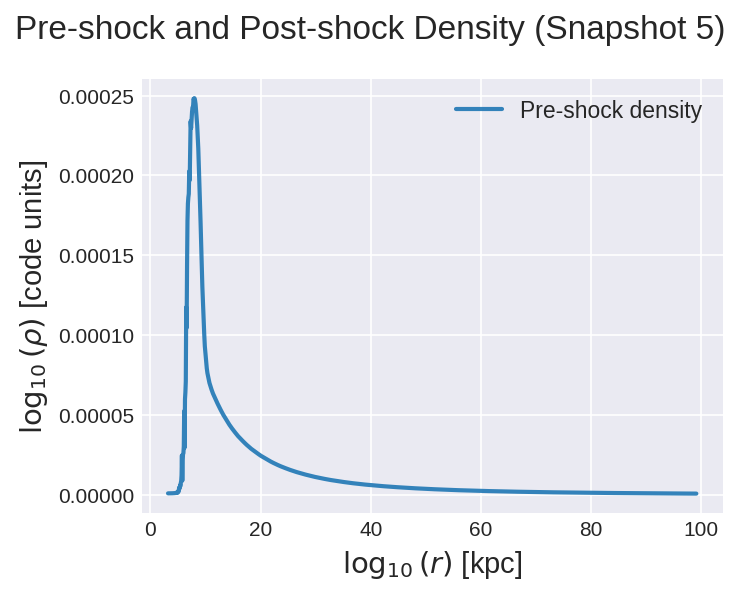

In [30]:
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
snappath = '/cosma8/data/dp317/dc-naza3/gasCloudNfw/output'

# Load snapshot 5
num = 5
r_plot, preshock = rvsval(value='rho', snappath=snappath, num=num, nbins=1000, shock=True)
# r_plot, postshock = rvsval(value='postshock_v', snappath=snappath, num=num, nbins=1000, shock=True)

# Apply mask
# mask = np.ones_like(r_plot, dtype=bool)    
mask = (np.log10(r_plot) > 0.5) & (np.log10(r_plot) < 2)

# Plot both pre-shock and post-shock density
ax.plot(r_plot[mask], preshock[mask], linewidth=2, alpha=0.9, label='Pre-shock density', color='tab:blue')
# ax.plot(np.log10(r_plot)[mask], np.log10(postshock)[mask], linewidth=2, alpha=0.9, label='Post-shock density', color='tab:orange')

plt.xlabel(r'$\log_{10}(r)$ [kpc]', fontsize=14)
plt.ylabel(r'$\log_{10}(\rho)$ [code units]', fontsize=14)
fig.suptitle('Pre-shock and Post-shock Density (Snapshot 5)', fontsize=16)

ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

In [36]:
def shock_region_mask(mach, preshock_offset=10, postshock_offset=10):

    max_idx = int(np.nanargmax(mach))
    start = max(0, max_idx - preshock_offset)
    end = min(len(mach), max_idx + postshock_offset + 1)
    preshock_mask = np.zeros_like(mach, dtype=bool)
    postshock_mask = np.zeros_like(mach, dtype=bool)
    postshock_mask[start:max_idx] = True
    preshock_mask[max_idx:end] = True
    
    # ratio = np.nan if (np.isnan(mean_preshock) or mean_preshock == 0) else mean_postshock / mean_preshock
    return max_idx, preshock_mask, postshock_mask

def get_mean(chosen_values, mask):
    """
    Return mean of chosen values within the given mask.
    """
    values = chosen_values[mask]

    def safe_nanmean(values):
        valid = np.isfinite(values)
        return np.mean(values[valid]) if np.any(valid) else np.nan

    mean_value = safe_nanmean(values)
    return mean_value

if num<=20: shock = True
else: shock = False

r_plot, mach = rvsval(value='mach', snappath=snappath, num=num, nbins=1000, shock=shock)
r_plot, rho = rvsval(value='rho', snappath=snappath, num=num, nbins=1000, shock=shock)

mask = (np.log10(r_plot) > 0.5) & (np.log10(r_plot) < 2)

preshock_offset = 100
postshock_offset = 100
mach = mach[mask]
max_idx, preshock_mask, postshock_mask = shock_region_mask(mach, preshock_offset=preshock_offset, postshock_offset=postshock_offset)
preshock_mask = preshock_mask & (mach==0)
preshock_mask = preshock_mask & (mach==0)
rho_pre = get_mean(rho[mask], preshock_mask)
rho_post = get_mean(rho[mask], postshock_mask)
rho_post/rho_pre

/tmp/ipykernel_1683668/1916465506.py:84: RuntimeWarning: Mean of empty slice.
  val_binned = np.array([s.data[value][bin_indices == i].mean()


2.2513866

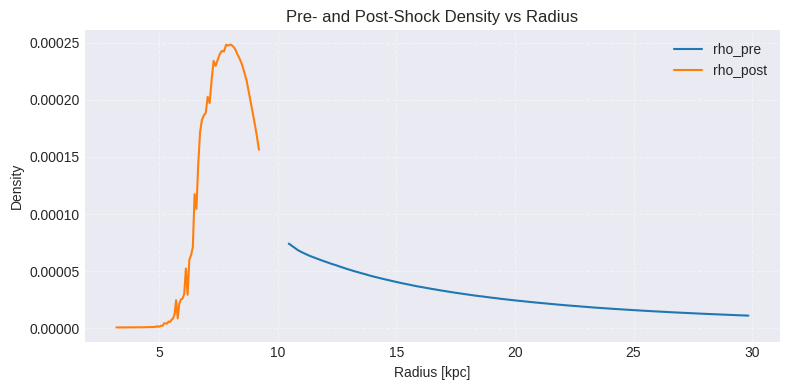

In [38]:
plt.figure(figsize=(8, 4))
plt.plot(r_plot[mask][preshock_mask], rho[mask][preshock_mask], label='rho_pre', color='tab:blue')
plt.plot(r_plot[mask][postshock_mask], rho[mask][postshock_mask], label='rho_post', color='tab:orange')
plt.xlabel('Radius [kpc]')
plt.ylabel('Density')
plt.title('Pre- and Post-Shock Density vs Radius')
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.tight_layout()

In [41]:
v_pre = get_mean(vrad, preshock_mask)
v_post = get_mean(vrad, postshock_mask)
(-(v_pre-vrad[max_idx])/(v_post-vrad[max_idx]))
# v_pre/v_post

NameError: name 'vrad' is not defined

In [39]:
max_mach = mach[max_idx]
(gamma+1)*max_mach**2/((gamma-1)*max_mach**2+2)

2.039072933070627

In [40]:
max_mach

1.766226

KeyboardInterrupt: 

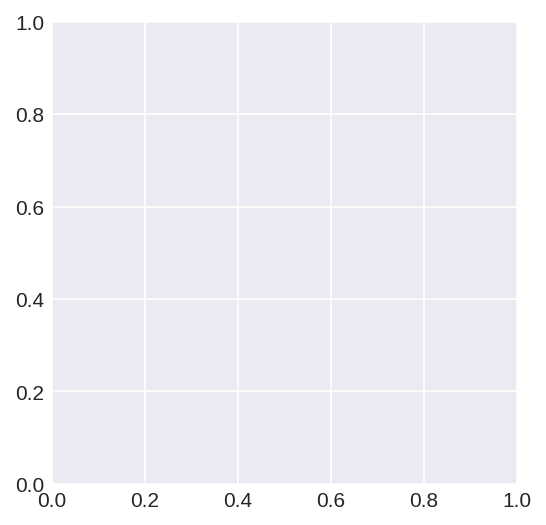

In [ ]:
plt.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

val = 'mach'
snappath = '/cosma8/data/dp317/dc-naza3/gasCloudNfw/output'
# Plot lines for all snapshots  
for i in range(0,29,4):
    if i<=20: shock = True
    else: shock = False
    r_plot, val_plot = rvsval(value=val, snappath=snappath, num=i, nbins=1000, shock = shock)
    mask = (np.log10(r_plot)>0.5) & (np.log10(r_plot)<2) # #np.ones_like(r_plot, dtype=bool)
    ax.plot(np.log10(r_plot)[mask], np.log10(val_plot)[mask], alpha=0.9, label=f'Snap {i}')


# Find normalization so the comparison curves land in same y-range as data
# rho0 = rho_plot10[0]

# rho_prof = rho_nfw(r_plot10, r_s, delta_c, rho_c_10Msun_per_kpc3)
# ax.plot(np.log10(r_plot10), np.log10((1-0.844)*rho_prof), '--', color='k', label=r'$\rho$ nfw', alpha=0.7)

# ax.plot(np.log10(r_plot10), np.log10(rho0 * (r_plot10/r_plot10[0])**-1), '--', color='dodgerblue', label=r'$\rho \propto r^{-1}$', alpha=0.7)
# ax.plot(np.log10(r_plot10), np.log10(rho0 * (r_plot10/r_plot10[0])**-2), '--', color='forestgreen', label=r'$\rho \propto r^{-2}$', alpha=0.7)
# ax.plot(np.log10(r_plot10), np.log10(rho0 * (r_plot10/r_plot10[0])**-3), '--', color='orange', label=r'$\rho \propto r^{-3}$', alpha=0.7)
# plt.axvline(np.log10(kpc_rs), linestyle='--', linewidth=0.5, color='red')
current = plt.xticks()[0]  
# plt.xticks(list(current)+[np.log10(kpc_rs)])

plt.xlabel(r'$log(r) [kpc]$', fontsize=14)
plt.ylabel('log(' + val + ')', fontsize=14)
fig.suptitle(val.capitalize(), fontsize=16)

ax.legend(fontsize=11)

plt.tight_layout()
plt.show()